<a href="https://colab.research.google.com/github/GeorgeTsio/Parkinson-s_Disease_Detection_Using_ML_Algorithms/blob/main/Parkinson's_Disease_Detection_Using_ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**

Does Parkinson Disease (PD) affect patient's voice? Emerging evidence suggests voice dysfunction is the earliest sign of motor impairment in PD.

**About the dataset:**
This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds to one of 195 voice recordings from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to the "status" column which is set to 0 for healthy and 1 for PD.

**Matrix column entries (attributes):**

* name - ASCII subject name and recording number
* MDVP:Fo(Hz) - Average vocal fundamental frequency
* MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
* MDVP:Flo(Hz) - Minimum vocal fundamental frequency
* Five measures of variation in Frequency
* MDVP:Jitter(%) - Percentage of cycle-to-cycle variability of the period duration
* MDVP:Jitter(Abs) - Absolute value of cycle-to-cycle variability of the period duration
* MDVP:RAP - Relative measure of the pitch disturbance
* MDVP:PPQ - Pitch perturbation quotient
* Jitter:DDP - Average absolute difference of differences between jitter cycles
* Six measures of variation in amplitude
* MDVP:Shimmer - Variations in the voice amplitdue
* MDVP:Shimmer(dB) - Variations in the voice amplitdue in dB
* Shimmer:APQ3 - Three point amplitude perturbation quotient measured against the average of the three amplitude
* Shimmer:APQ5 - Five point amplitude perturbation quotient measured against the average of the three amplitude
* MDVP:APQ - Amplitude perturbation quotient from MDVP
* Shimmer:DDA - Average absolute difference between the amplitudes of consecutive periods
* Two measures of ratio of noise to tonal components in the voice
* NHR - Noise-to-harmonics Ratio and
* HNR - Harmonics-to-noise Ratio
* status - Health status of the subject (one) - Parkinson's, (zero) - healthy
* Two nonlinear dynamical complexity measures
* RPDE - Recurrence period density entropy
* D2 - correlation dimension
* DFA - Signal fractal scaling exponent
* Three nonlinear measures of fundamental frequency variation
* spread1 - discrete probability distribution of occurrence of relative semitone variations
* spread2 - Three nonlinear measures of fundamental frequency variation
* PPE - Entropy of the discrete probability distribution of occurrence of relative semitone variations



### **Load the data from kaggle**

In [1]:
import requests
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# PyTorch
import torch
from torch import nn


from pathlib import Path
from google.colab import files
from tqdm import tqdm

In [2]:
# Upload kaggle.json from your profile in kaggle
files.upload()

# Install kaggle API client
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle, so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy and paste the API command of your data
!kaggle datasets download -d vikasukani/parkinsons-disease-data-set

# Unzip the file
data_path = Path("parkinsons-disease-data-set")

with zipfile.ZipFile("parkinsons-disease-data-set.zip") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(data_path)
  print("Done!")

Saving kaggle.json to kaggle.json
  0% 0.00/15.6k [00:00<?, ?B/s]
100% 15.6k/15.6k [00:00<00:00, 44.1MB/s]
Unzipping data...
Done!


In [3]:
# Import the data
park_data = pd.read_csv(data_path / "parkinsons.data", sep=',')

# Check if we import it correctly
print(f"Shape of data: {park_data.shape}")
park_data.head()

Shape of data: (195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### **Data Exploration and pre-process steps**

In [4]:
# First of all I would like to move the `status` column, to the last column
target_column = ['status']
park_data = park_data[[column for column in park_data if column not in target_column]
                    + [column for column in target_column if column in park_data]]
park_data

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050,0
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895,0
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728,0
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306,0


In [5]:
# Descriptive statistics for each column
park_data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552,0.753846
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119,0.431878
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539,0.000000
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451,1.000000
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052,1.000000
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980,1.000000
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367,1.000000


Interpretetion of some values:

**MDVP:Fo(Hz)** : Fundamental frequency of voice in hertz. Wide range of values (88-260).

**MDVP:Fhi(Hz)** : Highest frequency of the voice. *Bigger* range (102-592) and bigger std.

**MDVP:Flo(Hz)** : Lowest freqeuncy of the voice. *Smaller* range (65-239).

**MDVP:Jitter(%)** : % variation in fundamental frequency. Low mean and std

**mdvp_Shimmer and mdvp_Shimmer(dB)**: Measures of voice shimmer, which relates to irregularities in amplitude. The values (range,std,mean) indicates variability in these features.

#### Check for missing values

In [6]:
park_data.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
status              0
dtype: int64

#### Check for duplicate rows

In [7]:
park_data.duplicated().sum()

0

#### Parkinson vs Healthy

In [8]:
print(f"Number of healthy people: {park_data['status'].value_counts()[0]}")
print(f"Number of Parkinson people: {park_data['status'].value_counts()[1]}")

Number of healthy people: 48
Number of Parkinson people: 147


### **Let's check the distribution of some variables**

#### Feature : MDVP:Fo(Hz) - Based on status

<ipython-input-9-a07282db75a9>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Fo(Hz)'], bins=30, kde=True, label='Healthy')
<ipython-input-9-a07282db75a9>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 1][

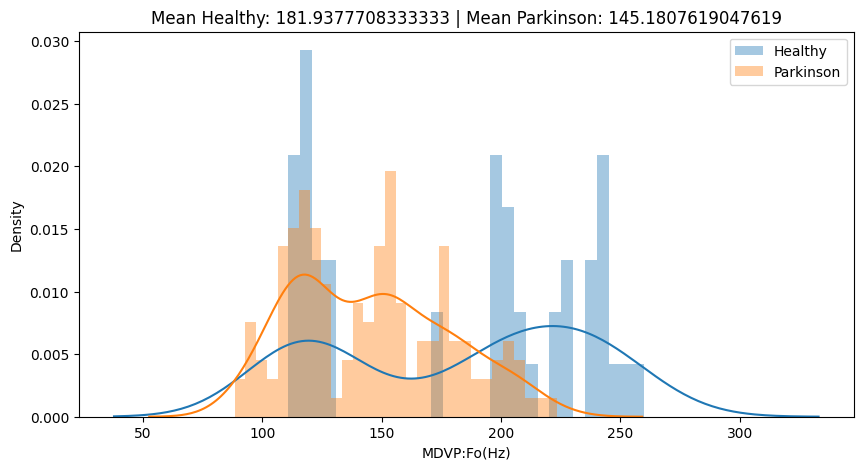

In [9]:
# Set figure size
plt.figure(figsize=(10, 5))

# Set the plot for Healthy people
fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Fo(Hz)'], bins=30, kde=True, label='Healthy')

# Set the plot for parkinson people
fig = sns.distplot(park_data[park_data['status'] == 1]['MDVP:Fo(Hz)'], bins=30, kde=True, label='Parkinson')

plt.title(f"Mean Healthy: {park_data[park_data['status']==0]['MDVP:Fo(Hz)'].mean()} | Mean Parkinson: {park_data[park_data['status']==1]['MDVP:Fo(Hz)'].mean()}")
plt.legend()
plt.show()

**Comment:** As we observe Healthy people (blue) are divided into two groups (We also have two peaks). This is probably because of sex (A man has different frequencies in his voice than a woman). However, this phenomeno is not visible in parkinson people. Also, Parkinson people tend to possess lower frequencies than healthy people. This is more clearly in the boxplot below.

<ipython-input-10-b4ca3826b3e5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=park_data['status'], y=park_data['MDVP:Fo(Hz)'], palette=colors)


<Axes: xlabel='status', ylabel='MDVP:Fo(Hz)'>

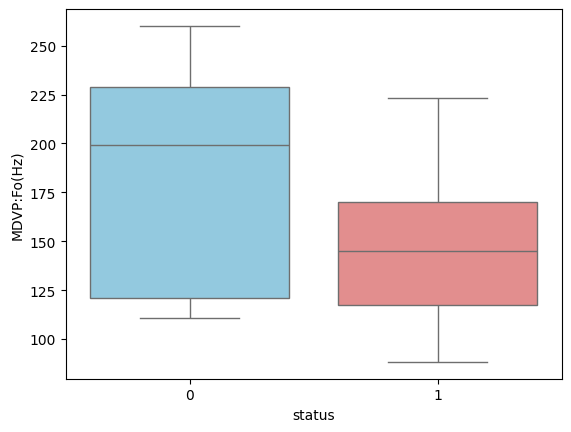

In [10]:
# Boxplot for the attribute MDVP:Fo(Hz)

# Set the colors
colors = ["skyblue", "lightcoral"]

# Create the boxplot
sns.boxplot(x=park_data['status'], y=park_data['MDVP:Fo(Hz)'], palette=colors)

<Axes: xlabel='MDVP:Fo(Hz)'>

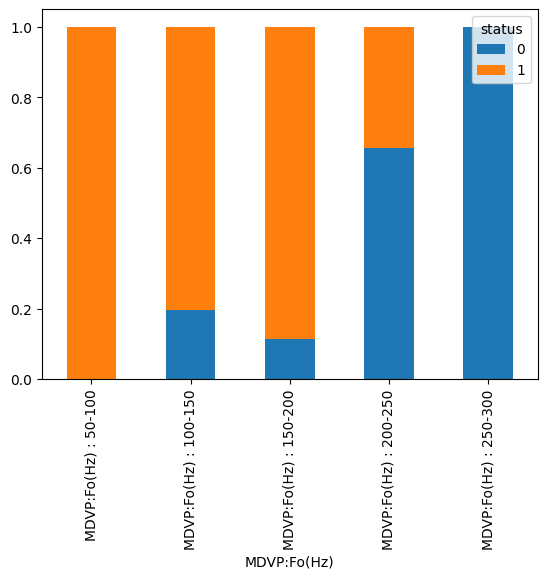

In [11]:
# Let's make an another graph in order to make some better conclusions about our data
# Create the groups
bins = [50, 100, 150, 200, 250, 300]

# Name the groups
mdvp_fo_hz_group = ['MDVP:Fo(Hz) : 50-100', 'MDVP:Fo(Hz) : 100-150', 'MDVP:Fo(Hz) : 150-200', 'MDVP:Fo(Hz) : 200-250', 'MDVP:Fo(Hz) : 250-300']

# Create the plot
pdData_mdvp_fo_hz_bin = pd.cut(park_data['MDVP:Fo(Hz)'], bins, labels=mdvp_fo_hz_group)

mdvp_fo_hz_group_col = pd.crosstab(pdData_mdvp_fo_hz_bin,park_data.status).apply(lambda r: r/r.sum()*100, axis=1)

mdvp_fo_hz_group_col.div(mdvp_fo_hz_group_col.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

**Comment:** People with 50-100 Hz have all of them Parkinson. People with 250-300 Hz are all healthy. The percentage of people with Parkinson's disease decreases as we observe higher Hz values.

#### Feature : MDVP: Fhi(Hz) - Based on status

<ipython-input-12-4d9f09b797ac>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Fhi(Hz)'], bins=30, kde=True, label='Healthy')
<ipython-input-12-4d9f09b797ac>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 

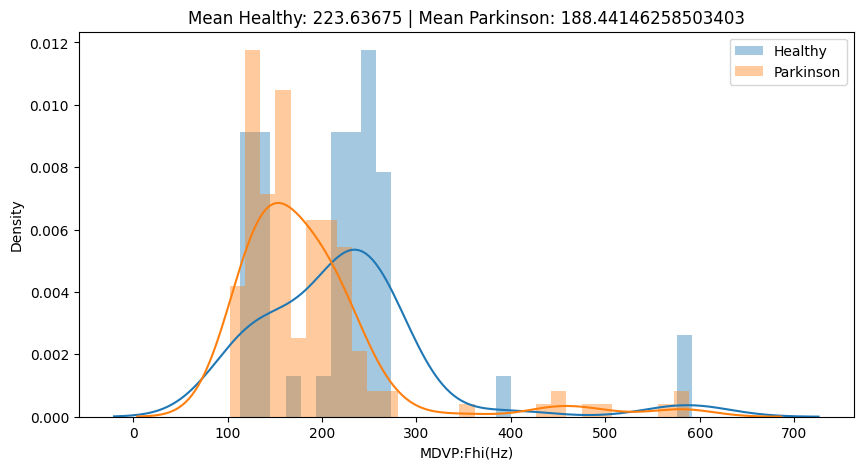

In [12]:
# Set figure size
plt.figure(figsize=(10, 5))

# Set the plot for Healthy people
fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Fhi(Hz)'], bins=30, kde=True, label='Healthy')

# Set the plot for parkinson people
fig = sns.distplot(park_data[park_data['status'] == 1]['MDVP:Fhi(Hz)'], bins=30, kde=True, label='Parkinson')

plt.title(f"Mean Healthy: {park_data[park_data['status']==0]['MDVP:Fhi(Hz)'].mean()} | Mean Parkinson: {park_data[park_data['status']==1]['MDVP:Fhi(Hz)'].mean()}")
plt.legend()
plt.show()

**Comment:** Again people with parkinson tend to have lower values than healthy people.

<ipython-input-13-96c4c5d875f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=park_data['status'], y=park_data['MDVP:Fhi(Hz)'], palette=colors)


<Axes: xlabel='status', ylabel='MDVP:Fhi(Hz)'>

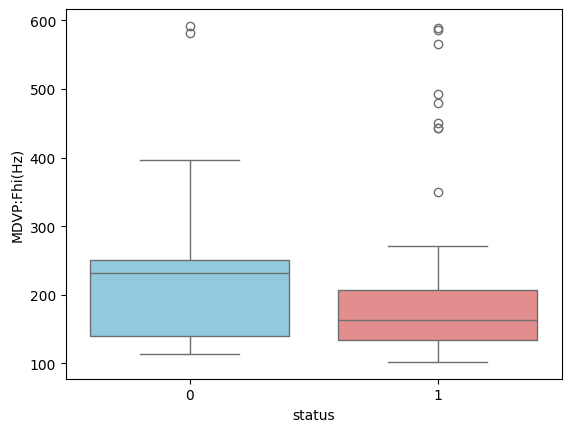

In [13]:
# Create a boxplot for the attribute MDVP:Fhi(Hz)
sns.boxplot(x=park_data['status'], y=park_data['MDVP:Fhi(Hz)'], palette=colors)

#### Feature : MDVP: Flo(Hz) - Based on status

<ipython-input-14-b02e9f8b42cd>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Flo(Hz)'], bins=30, kde=True, label='Healthy')
<ipython-input-14-b02e9f8b42cd>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(park_data[park_data['status'] == 

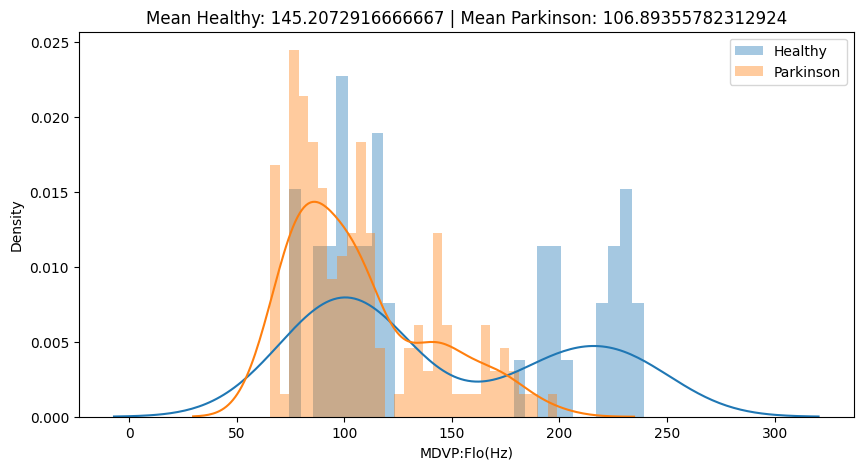

In [14]:
# Set figure size
plt.figure(figsize=(10, 5))

# Set the plot for Healthy people
fig = sns.distplot(park_data[park_data['status'] == 0]['MDVP:Flo(Hz)'], bins=30, kde=True, label='Healthy')

# Set the plot for parkinson people
fig = sns.distplot(park_data[park_data['status'] == 1]['MDVP:Flo(Hz)'], bins=30, kde=True, label='Parkinson')

plt.title(f"Mean Healthy: {park_data[park_data['status']==0]['MDVP:Flo(Hz)'].mean()} | Mean Parkinson: {park_data[park_data['status']==1]['MDVP:Flo(Hz)'].mean()}")
plt.legend()
plt.show()

**Comment:** Healthy people are divided in two groups. Max value of parkinson people is ~180 while on healthy people the max value is ~270.

<Axes: xlabel='MDVP:Flo(Hz)'>

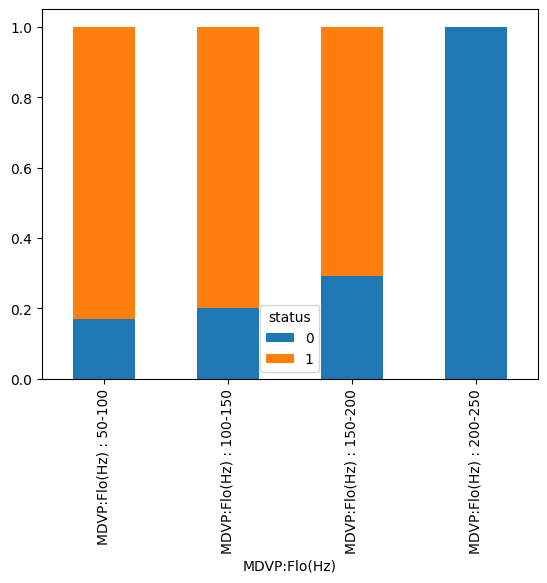

In [15]:
# Let's make an another graph in order to make some better conclusions about our data
# Create the groups
bins = [50, 100, 150, 200, 250]

# Name the groups
mdvp_fo_hz_group = ['MDVP:Flo(Hz) : 50-100', 'MDVP:Flo(Hz) : 100-150', 'MDVP:Flo(Hz) : 150-200', 'MDVP:Flo(Hz) : 200-250']

# Create the plot
pdData_mdvp_fo_hz_bin = pd.cut(park_data['MDVP:Flo(Hz)'], bins, labels=mdvp_fo_hz_group)

mdvp_fo_hz_group_col = pd.crosstab(pdData_mdvp_fo_hz_bin,park_data.status).apply(lambda r: r/r.sum()*100, axis=1)

mdvp_fo_hz_group_col.div(mdvp_fo_hz_group_col.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

**Comment:** People that belong to the last group (200-250 Hz) are all healthy. At the other groups the percentage of Parkinson people is higher.

<ipython-input-16-6c01e93571f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=park_data['status'], y=park_data['MDVP:Flo(Hz)'], palette=colors)


<Axes: xlabel='status', ylabel='MDVP:Flo(Hz)'>

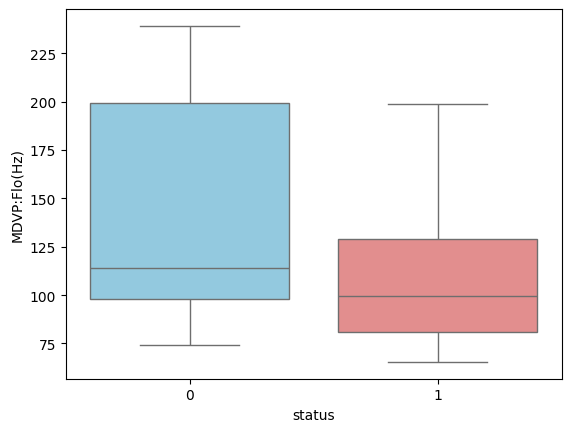

In [16]:
# Create a boxplot for the attribute MDVP:Flo(Hz)
sns.boxplot(x=park_data['status'], y=park_data['MDVP:Flo(Hz)'], palette=colors)

#### Let's check the distribution of the other variables too

##### Histplots

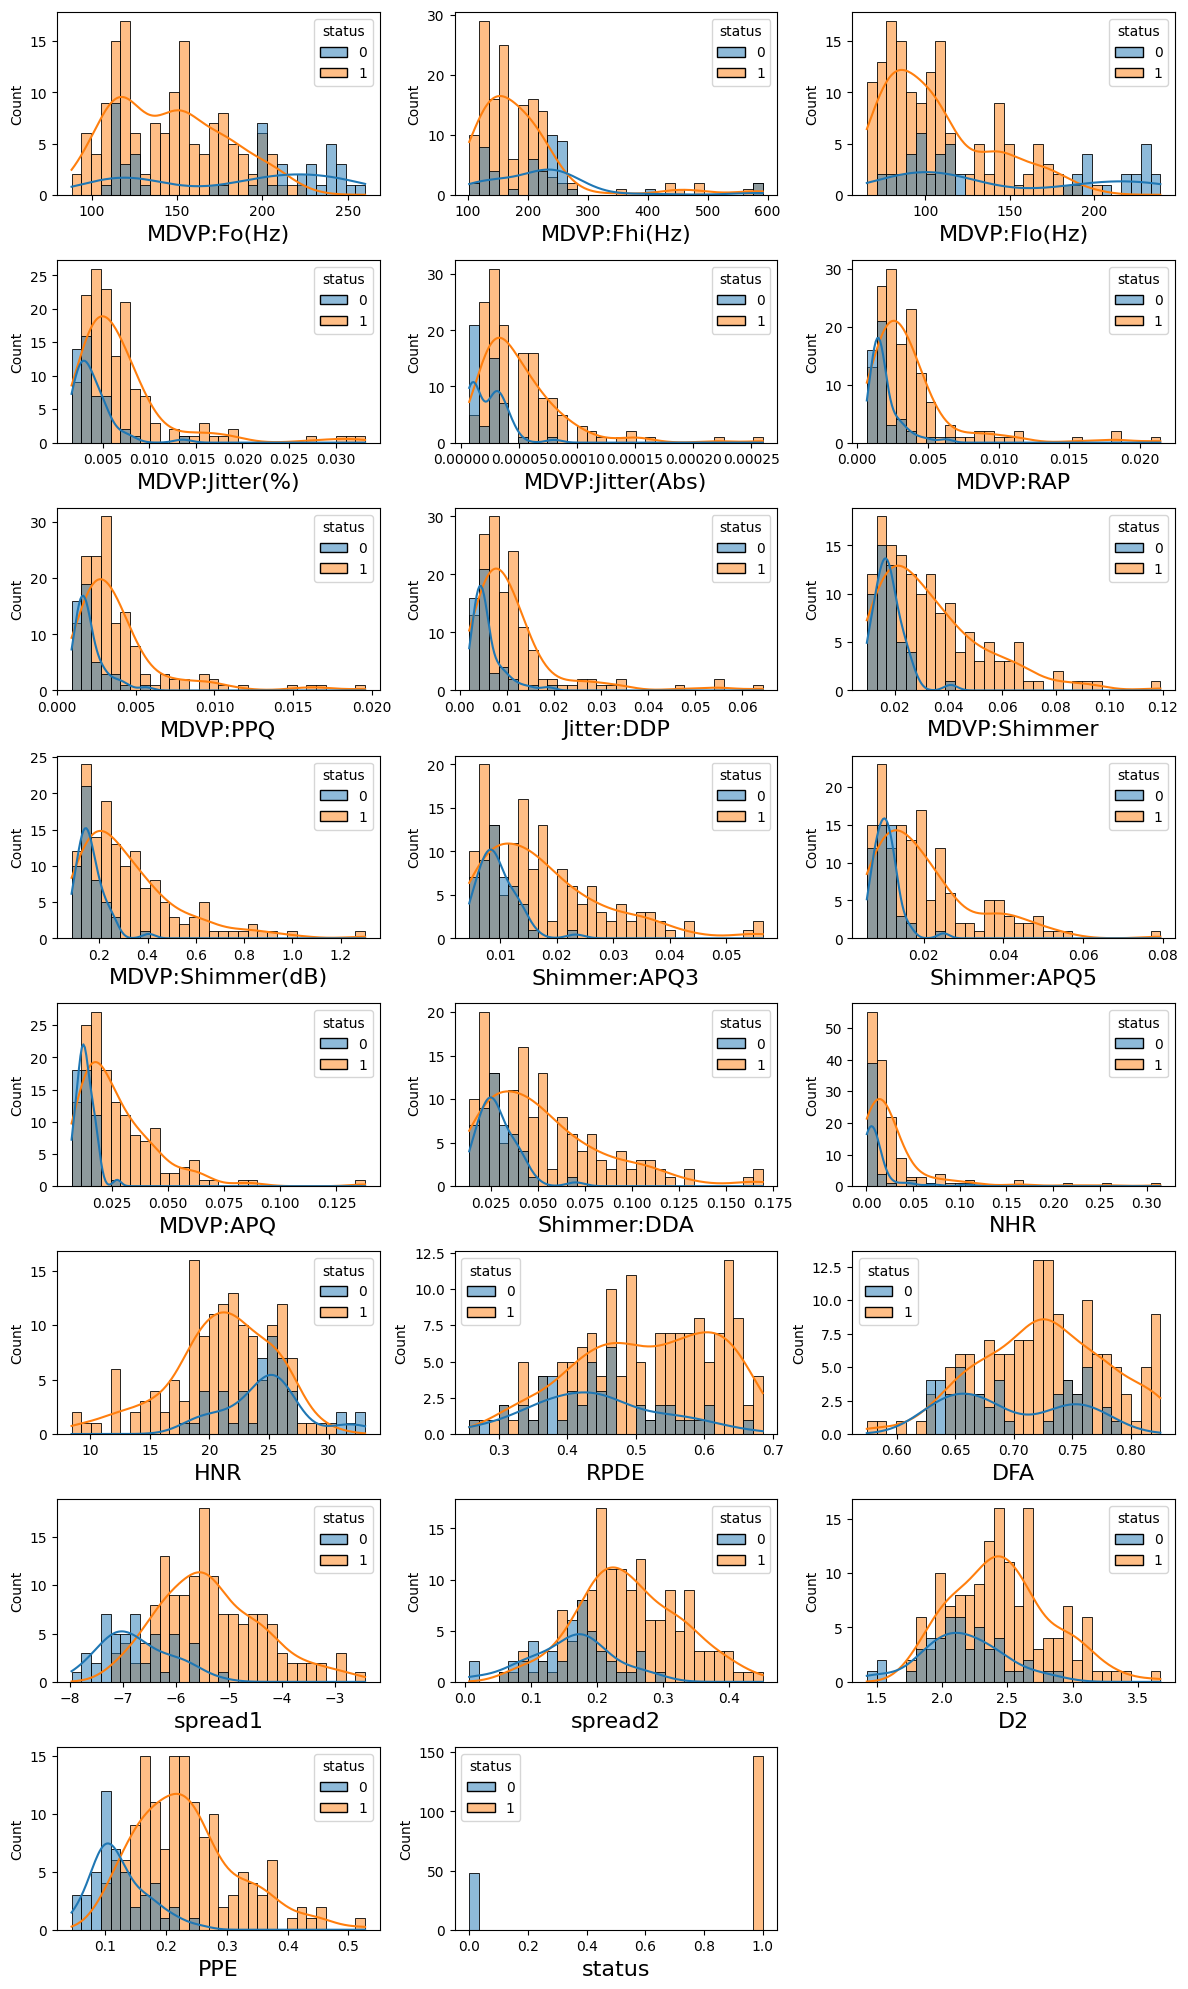

In [17]:
# Set the figure with the figure size
fig = plt.figure(figsize = (12, 20))

for i, column_name in enumerate(park_data.columns):

    # 'name' column is a string variable
    if column_name != "name":
      fig.add_subplot(8, 3, i)
      plot = sns.histplot(data=park_data, x = column_name, bins=30, kde=True, hue = 'status')
      plot.set_xlabel(column_name, fontsize = 16)
plt.tight_layout()

**Comment:** In every variable there is a difference (small or big) between Parkinson and Healthy people.

##### Boxplots

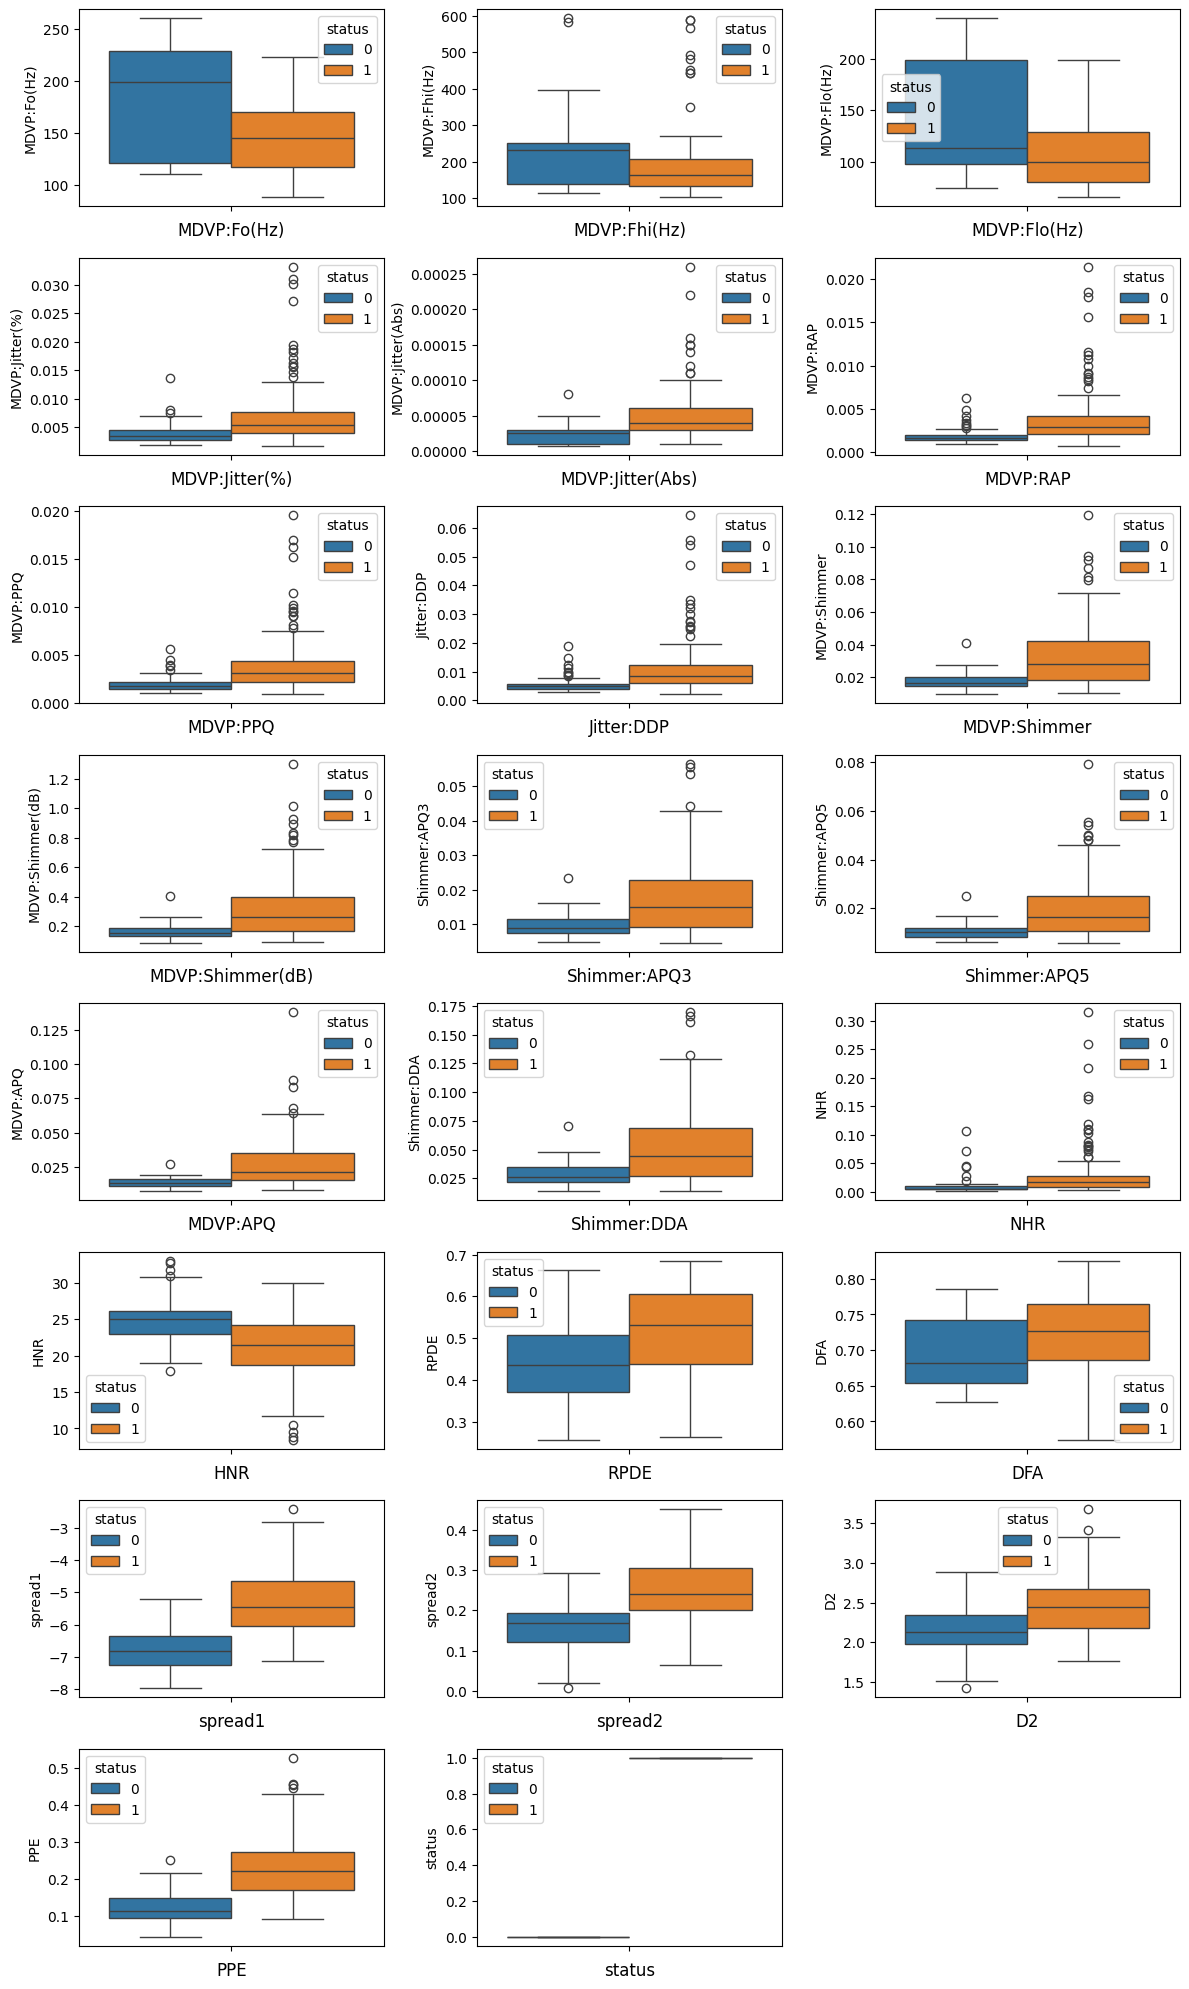

In [18]:
# Set the figure with the figure size
fig = plt.figure(figsize = (12, 20))

for i, column_name in enumerate(park_data.columns):

    # 'name' column is a string variable
    if column_name != "name":
      fig.add_subplot(8, 3, i)
      plot = sns.boxplot(data=park_data, y = column_name, hue = 'status')
      plot.set_xlabel(column_name, fontsize = 12)
plt.tight_layout()

**Comment:** Also, from that type of graphs there is a difference between healthy and people with parkinson disease, in every case

#### Correlation graph

<ipython-input-19-e3d6e6e8a282>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(park_data.corr(), annot=True, cmap=cmap)


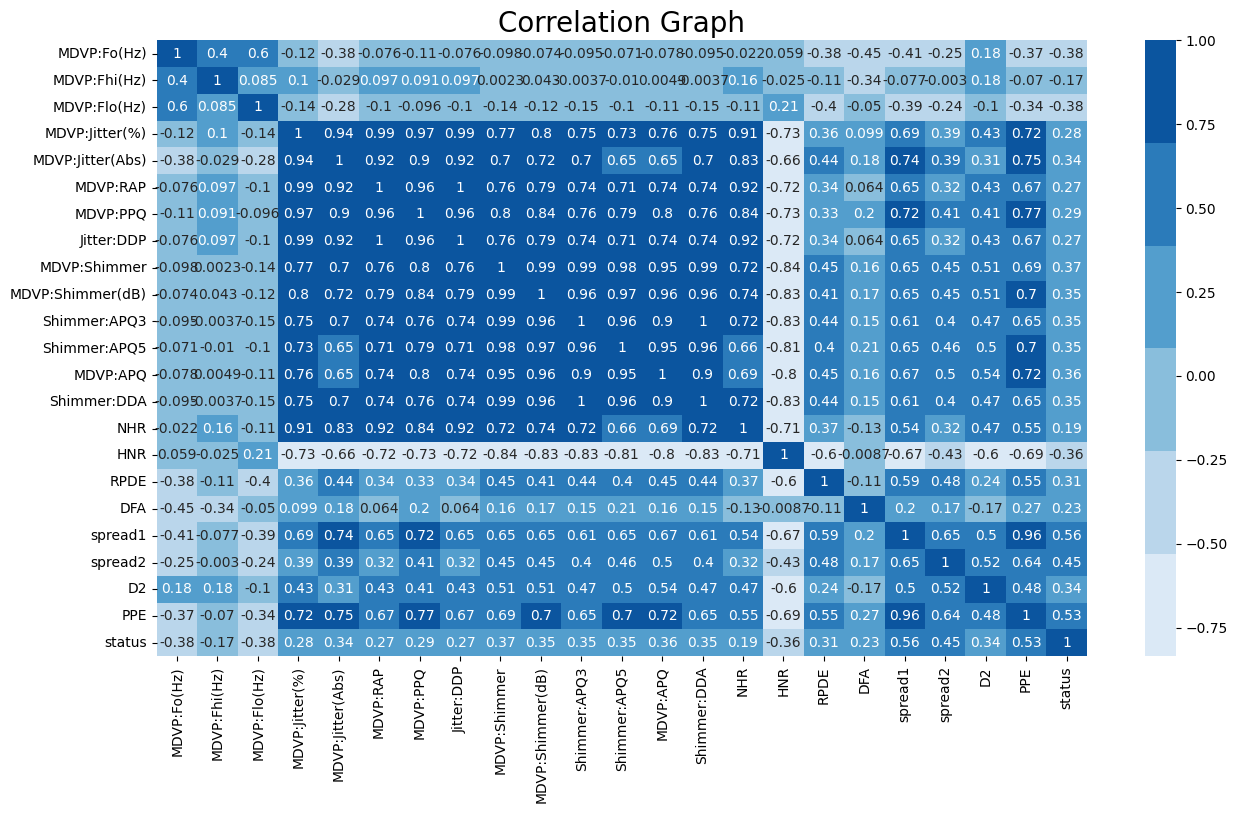

In [19]:
# Figure size
plt.figure(figsize=[15, 8], dpi=100)

# Figure title
plt.title("Correlation Graph", fontsize=20)

# Colors
cmap = sns.color_palette("Blues")

# Heatmap with correlation numbers of each variable
sns.heatmap(park_data.corr(), annot=True, cmap=cmap)
plt.show()

**Comment:** Strong correlation between these variables: MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA. There is also significant correlation between these variables: MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP

### **Let's now build different models to fit our data**

In [20]:
# Define X and y
# X will not contain the first column (names) and the last (status)
X = park_data.iloc[:, 1:-1]

# y will contain only status
y = park_data['status']

In [21]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (156, 22)
y_train shape: (156,)
X_test shape: (39, 22)
y_test shape: (39,)


**!Important:!** Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.

In [22]:
# Create an instance of MinMaxScaler
minmax = MinMaxScaler()

# Normalize the data, y doesn't need to transformed as it contains only 0 and 1
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

#### **Building an evaluation function**

In [23]:
def evaluation(Model, X_train, y_train, X_test, y_test):

  Model.fit(X_train, y_train)
  overall_score = cross_val_score(Model, X_train, y_train, cv = 10)
  model_score = np.average(overall_score)

  y_pred = Model.predict(X_test)

  print(f"\n • Training Accuracy Score : {round(Model.score(X_train, y_train) * 100, 2)}")
  print(f"\n • Cross Validation Score : {round(model_score * 100, 2)}")

  accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
  print(f"\n ✮ Testing accuracy Score : {accuracy}")

  precision = round(precision_score(y_test, y_pred) * 100, 2)
  print(f"\n • Precision Score : {precision}")

  recall = round(recall_score(y_test, y_pred) * 100, 2)
  print(f"\n • Recall Score : {recall}")

  F1_score = round(f1_score(y_test, y_pred) * 100, 2)
  print(f"\n • F1 Score : {F1_score}")

  print("-"*80)

  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, annot_kws={"size": 16})
  plt.title('Predicted Labels', y = 1.05, fontsize=20)
  plt.ylabel('True Labels', labelpad=25, fontsize=20)
  plt.show()
  print("-"*80)

  results = {}
  results = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": F1_score}
  return results


#### **Logestic regression**

--------------------------------------------------
Logistic Regression: 

 • Training Accuracy Score : 85.26

 • Cross Validation Score : 83.87

 ✮ Testing accuracy Score : 89.74

 • Precision Score : 88.89

 • Recall Score : 100.0

 • F1 Score : 94.12
--------------------------------------------------------------------------------


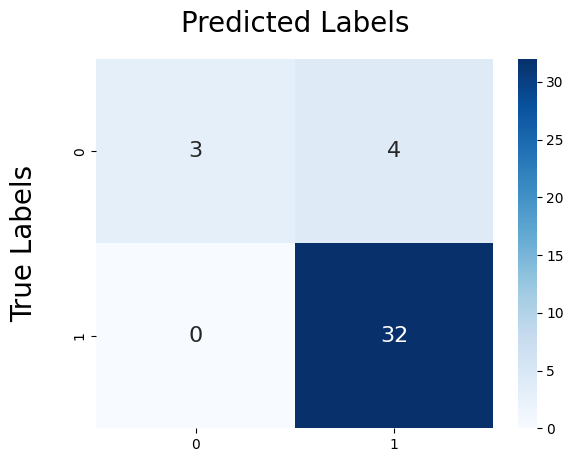

--------------------------------------------------------------------------------


In [24]:
LogReg = LogisticRegression()
print("-"*50)
print("Logistic Regression: ")
results_LogReg = evaluation(LogReg, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_LogReg["Model"] = "Logistic Regression"

#### **Support Vector Machine**

--------------------------------------------------
Support Vector Machine: 

 • Training Accuracy Score : 88.46

 • Cross Validation Score : 87.67

 ✮ Testing accuracy Score : 89.74

 • Precision Score : 88.89

 • Recall Score : 100.0

 • F1 Score : 94.12
--------------------------------------------------------------------------------


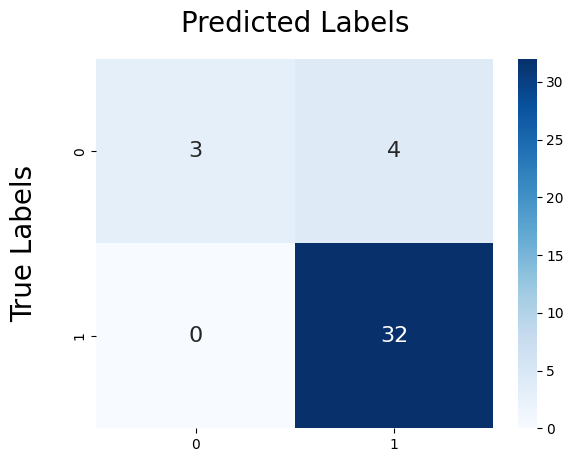

--------------------------------------------------------------------------------


In [25]:
SVM = SVC(probability = True, kernel = 'linear')
print("-"*50)
print("Support Vector Machine: ")
results_SVM = evaluation(SVM, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_SVM["Model"] = "Support Vector Machine"

#### **Decision Tree Classifier**

--------------------------------------------------------------------------------
Decision Tree Classifier

 • Training Accuracy Score : 100.0

 • Cross Validation Score : 88.46

 ✮ Testing accuracy Score : 92.31

 • Precision Score : 93.94

 • Recall Score : 96.88

 • F1 Score : 95.38
--------------------------------------------------------------------------------


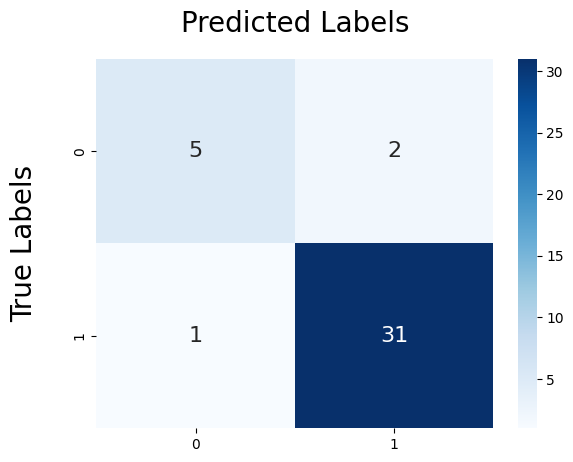

--------------------------------------------------------------------------------
Decision Tree:


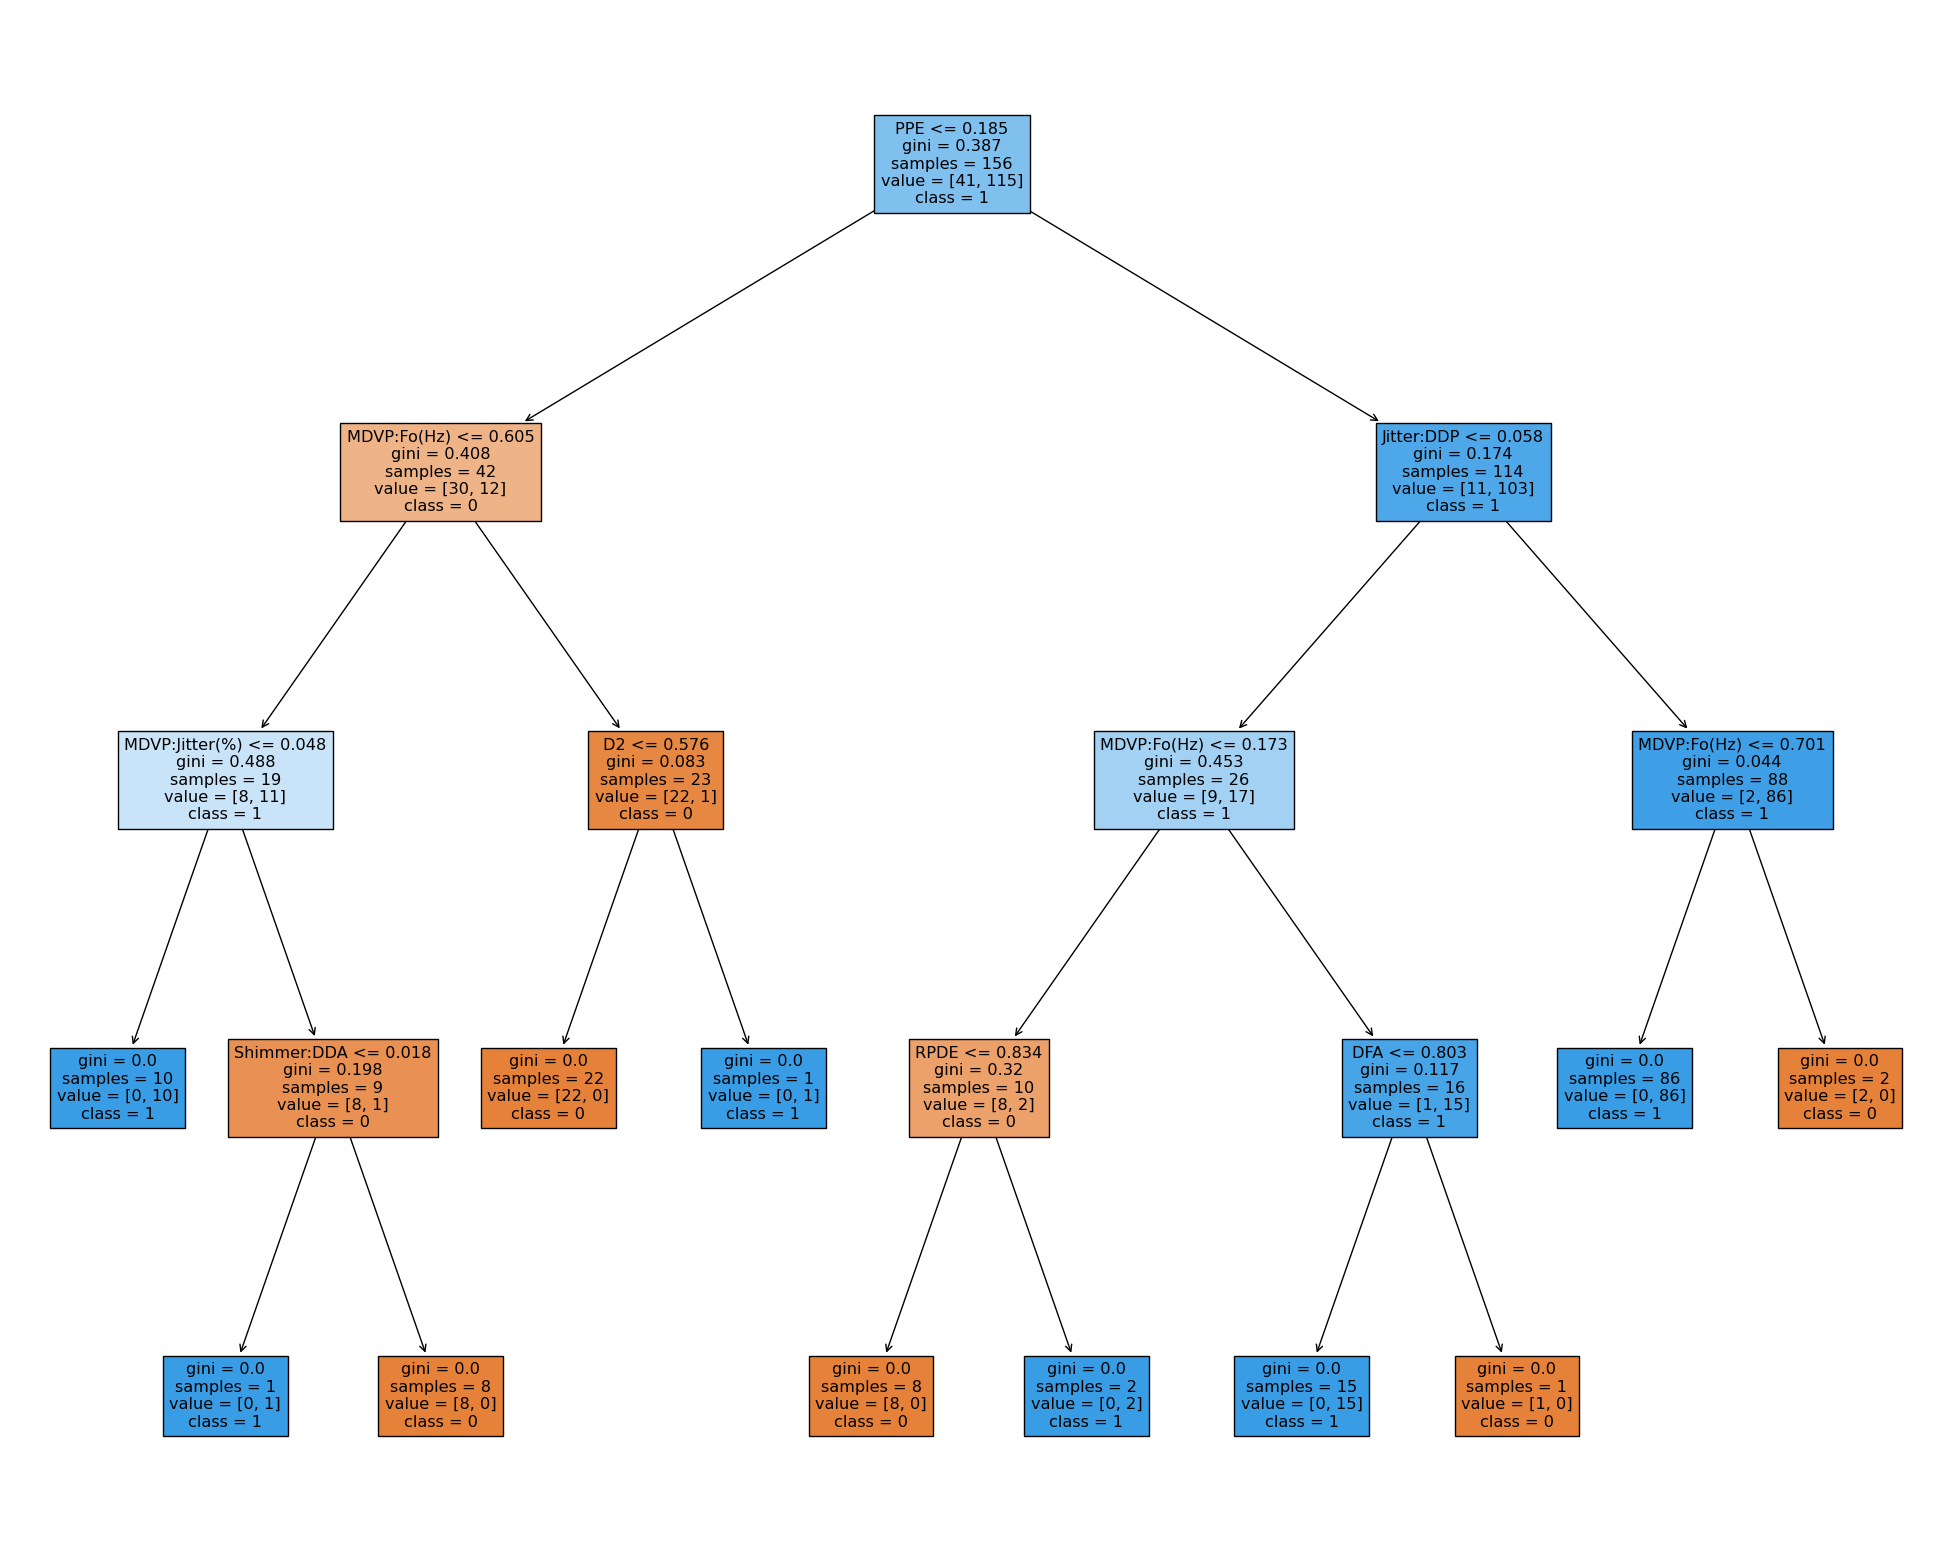

In [26]:
DTC = DecisionTreeClassifier()
print("-"*80)
print("Decision Tree Classifier")
results_DTC = evaluation(DTC, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_DTC["Model"] = "Decision Tree"

# Plot the decision tree

print("Decision Tree:")
fig = plt.figure(figsize = (25, 20))

# we want the classes (alternative: class_names=['0','1']) and the feature names
tree = plot_tree( DTC, feature_names = [ c for c in park_data.drop(['name'],axis=1).columns], class_names = np.array(np.sort(park_data['status'].unique()), dtype=str), filled = True )

#### **Random Forest Classifier**

--------------------------------------------------------------------------------
Random Forest Classifier

 • Training Accuracy Score : 100.0

 • Cross Validation Score : 89.62

 ✮ Testing accuracy Score : 94.87

 • Precision Score : 94.12

 • Recall Score : 100.0

 • F1 Score : 96.97
--------------------------------------------------------------------------------


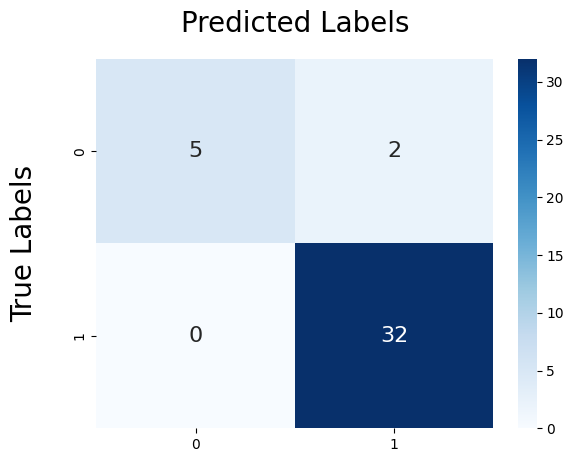

--------------------------------------------------------------------------------


In [27]:
RFC = RandomForestClassifier(n_estimators=120)
print("-"*80)
print("Random Forest Classifier")
results_RFC = evaluation(RFC, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_RFC["Model"] = "Random Forest"

#### **KNeighbors Classifier**

--------------------------------------------------------------------------------
KNeighbors Classifier

 • Training Accuracy Score : 96.79

 • Cross Validation Score : 89.79

 ✮ Testing accuracy Score : 94.87

 • Precision Score : 94.12

 • Recall Score : 100.0

 • F1 Score : 96.97
--------------------------------------------------------------------------------


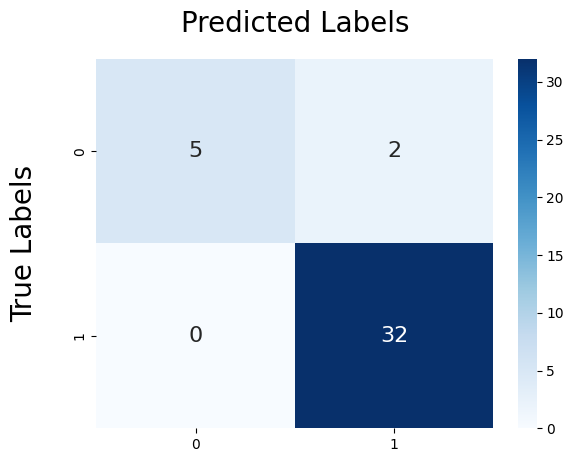

--------------------------------------------------------------------------------


In [28]:
KNN = KNeighborsClassifier()
print("-"*80)
print("KNeighbors Classifier")
results_KNN = evaluation(KNN, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_KNN["Model"] = "K Neighbors"

--------------------------------------------------------------------------------
Xtreme Gradient Boosting Classifier

 • Training Accuracy Score : 100.0

 • Cross Validation Score : 91.67

 ✮ Testing accuracy Score : 94.87

 • Precision Score : 94.12

 • Recall Score : 100.0

 • F1 Score : 96.97
--------------------------------------------------------------------------------


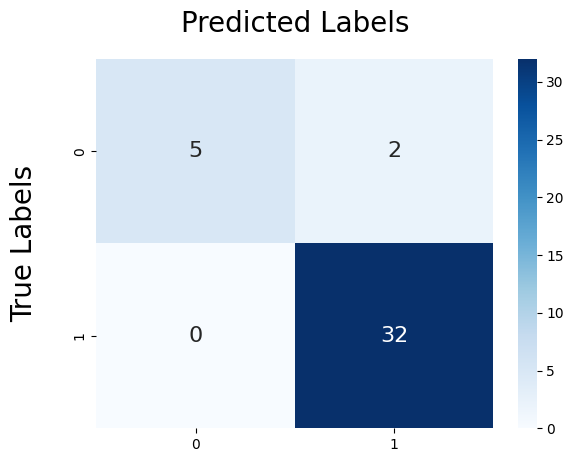

--------------------------------------------------------------------------------


In [29]:
XGB = XGBClassifier()
print("-"*80)
print("Xtreme Gradient Boosting Classifier")
results_XGB = evaluation(XGB, X_train_scaled, y_train, X_test_scaled, y_test)

# Append the name of the model for later display
results_XGB["Model"] = "XGBoost"

### **Combined Results**

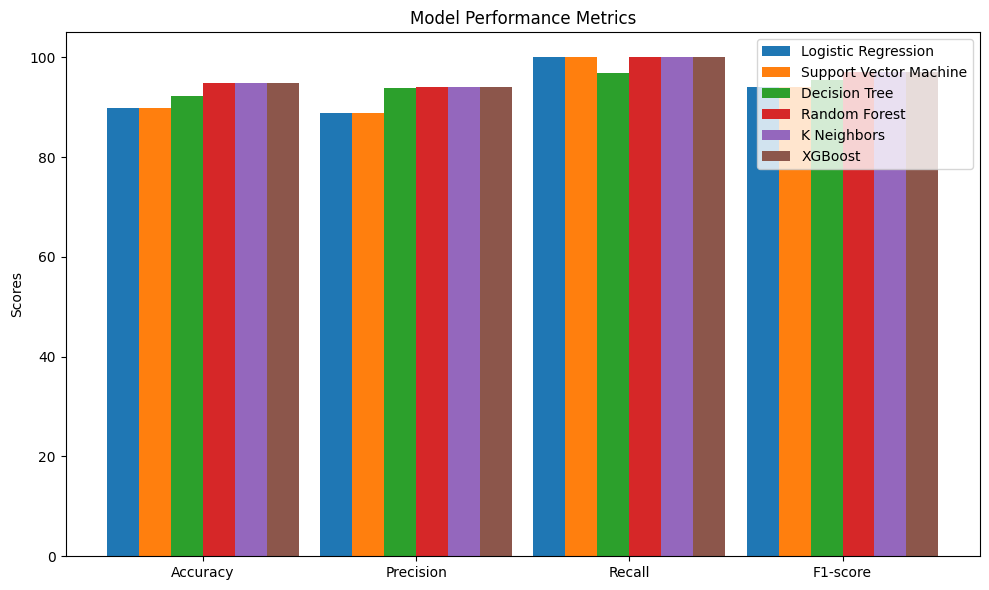

In [30]:
# Combine the results to a list
combined_results = [results_LogReg, results_SVM, results_DTC, results_RFC, results_KNN, results_XGB]

# Transform the list to a dataframe
results_df = pd.DataFrame(combined_results)

# Set the Model column as the index
results_df.set_index('Model', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Metrics for x labels
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
x = np.arange(len(metrics))
width = 0.15

for i, model in enumerate(results_df.index):
    values = results_df.loc[model, metrics]
    ax.bar(x + i * width, values, width, label=model)


ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x + (len(results_df) / 2 - 0.5) * width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

#### **Comments:** The best performance in all 4 metrics was by Random Forest, K-Neighbors and XGBoost. Decision Tree Classification has also quite good performance, while Logistic Regression and Support Vector Machine algorithms have only good Recall values.

### **Building my Neural Network with PyTorch**

At this section I would like to build my own Neural Network, using PyTorch, in order to make predictions about Parkinson's disease

#### **Define X and y tensors**

In [136]:
# X will not contain the first column (names) and the last (status)
X = park_data.iloc[:, 1:-1]

# Create an instance of MinMaxScaler
minmax = MinMaxScaler()

# Normalize the data, y doesn't need to transformed as it contains only 0 and 1
X = minmax.fit_transform(X)

# Transform it to tensor, X is numpy (after we transformed it)
X_tensor = torch.from_numpy(X).type(torch.float)

# y will contain only status
y = park_data['status']

# Transform it to tensor, y is  dataframe
y_tensor = torch.tensor(y.values).type(torch.float)

print(f"Shape of X tensor: {X_tensor.shape}")
print(f"Shape of y tensor: {y_tensor.shape}")

Shape of X tensor: torch.Size([195, 22])
Shape of y tensor: torch.Size([195])


#### **Split the data**

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Shape of X train: {X_train.shape}")
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y train: {y_train.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X train: torch.Size([156, 22])
Shape of X test: torch.Size([39, 22])
Shape of y train: torch.Size([156])
Shape of y test: torch.Size([39])


#### **Build the model**

In [138]:
class ParkinsonsDetection(nn.Module):
  def __init__(self, input_features, hidden_units, output_features):
    super().__init__()
    self.linear_layers_1 = nn.Sequential(
      nn.Linear(in_features = input_features, out_features = hidden_units),
      nn.Linear(in_features = hidden_units, out_features = hidden_units),
      nn.Linear(in_features = hidden_units, out_features = output_features))

  def forward(self, x):
    return self.linear_layers_1(x)

model0 = ParkinsonsDetection(X_train.shape[1], 10, 1)
model0

ParkinsonsDetection(
  (linear_layers_1): Sequential(
    (0): Linear(in_features=22, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

#### **Setup loss function and optimizer and accuracy function**

In [139]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model0.parameters(),
                            lr = 0.1)

# Accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

#### **Building a training loop**

In [140]:
torch.manual_seed(42)
EPOCHS = 120

#Create empty results dictionary
results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
          }

for epoch in range(EPOCHS):

  ###Training
  model0.train()

  # 1. Forward pass
  y_logits = model0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/acc
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_test, test_pred)

  # Print out what's happenin'
  print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  # Put everything together
  # Update results dictionary
  results["train_loss"].append(loss.item())
  results["train_acc"].append(acc)
  results["test_loss"].append(test_loss.item())
  results["test_acc"].append(test_acc)

Epoch: 0 | Loss:0.63493, Acc: 73.72% | Test loss: 0.60126, Test acc: 82.05%
Epoch: 1 | Loss:0.62659, Acc: 73.72% | Test loss: 0.59033, Test acc: 82.05%
Epoch: 2 | Loss:0.61895, Acc: 73.72% | Test loss: 0.58017, Test acc: 82.05%
Epoch: 3 | Loss:0.61196, Acc: 73.72% | Test loss: 0.57073, Test acc: 82.05%
Epoch: 4 | Loss:0.60555, Acc: 73.72% | Test loss: 0.56194, Test acc: 82.05%
Epoch: 5 | Loss:0.59967, Acc: 73.72% | Test loss: 0.55377, Test acc: 82.05%
Epoch: 6 | Loss:0.59428, Acc: 73.72% | Test loss: 0.54616, Test acc: 82.05%
Epoch: 7 | Loss:0.58934, Acc: 73.72% | Test loss: 0.53908, Test acc: 82.05%
Epoch: 8 | Loss:0.58481, Acc: 73.72% | Test loss: 0.53249, Test acc: 82.05%
Epoch: 9 | Loss:0.58066, Acc: 73.72% | Test loss: 0.52637, Test acc: 82.05%
Epoch: 10 | Loss:0.57685, Acc: 73.72% | Test loss: 0.52068, Test acc: 82.05%
Epoch: 11 | Loss:0.57335, Acc: 73.72% | Test loss: 0.51539, Test acc: 82.05%
Epoch: 12 | Loss:0.57015, Acc: 73.72% | Test loss: 0.51047, Test acc: 82.05%
Epoch: 13

#### **Plot loss curves**

In [141]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

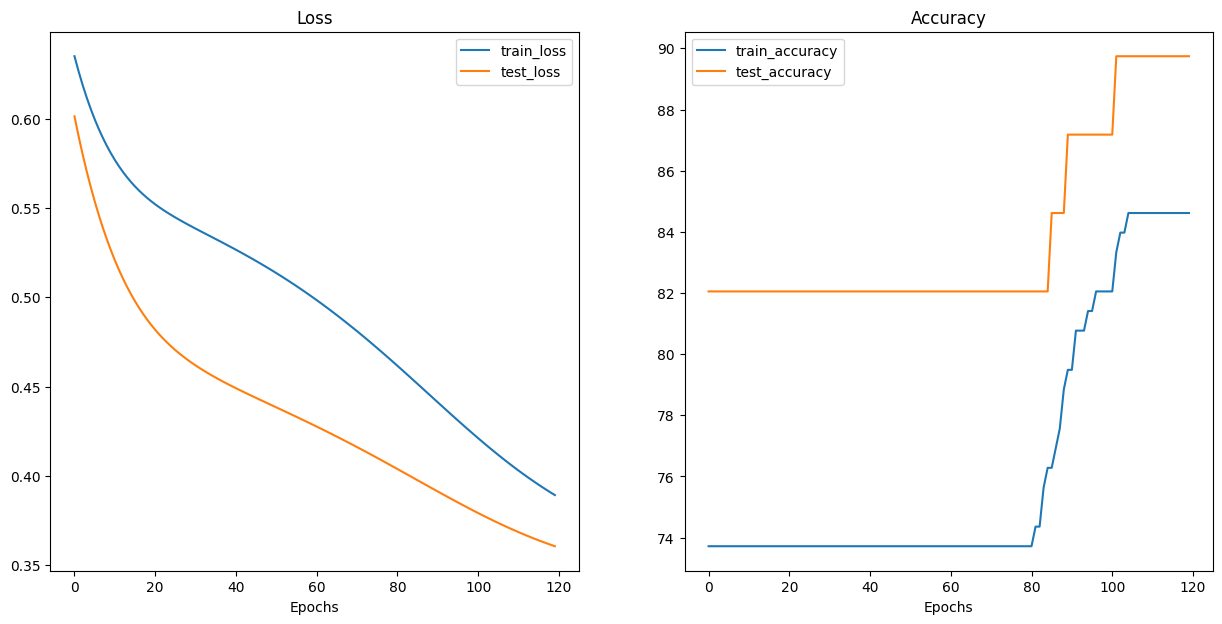

In [142]:
plot_loss_curves(results)

There are multiple ways to improve your model and some of them are:
* Fitting for longer (more epochs)
* More hidden units
* More layers

The three above gives more the opportunity to your model to look the data and therefore to learn more from them
* Change the learning rate
* Change the loss function

I tried plenty different and more complicated models, however it seems that the model performs better at its simplest form. I achieve 89.74% accuracy. Therefore, if we want to achieve a higher accuracy we maybe just need more data.